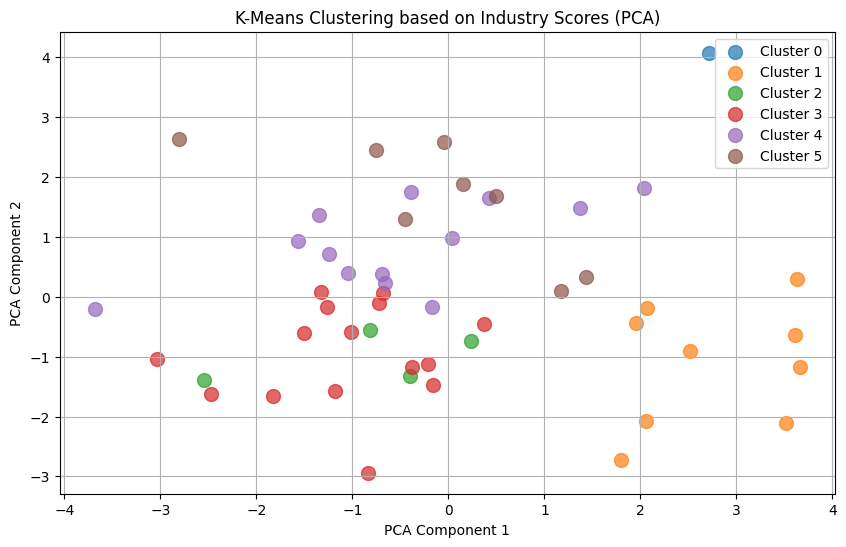

✅ 클러스터링 및 시각화 완료, 결과 시트 '클러스터링 결과'에 업로드됨.


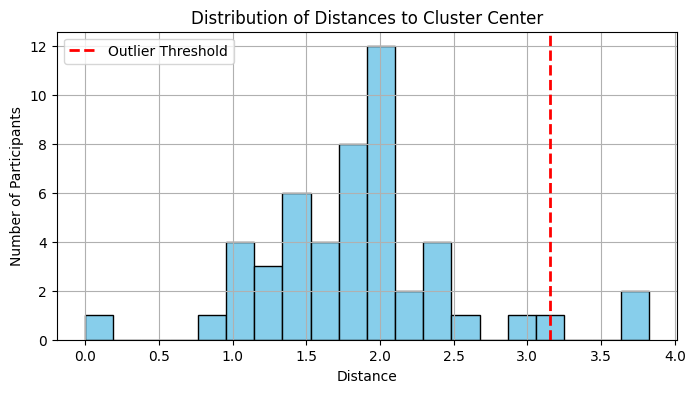

✅ Clustering + Distance Analysis completed and uploaded to 'Clustered Result with Distance'.


In [10]:
# ✅ 1. 라이브러리 설치 및 인증
!pip install --upgrade gspread gspread_dataframe oauth2client

from google.colab import auth
auth.authenticate_user()

import pandas as pd
import gspread
from gspread_dataframe import set_with_dataframe
from google.auth import default

# ✅ 2. 구글 시트 연결
creds, _ = default()
gc = gspread.authorize(creds)

# ✅ 3. 스프레드시트 열기
spreadsheet_url = "https://docs.google.com/spreadsheets/d/1kkt336f1G-XqfDuwCUOnqpKlxTcnwLQy-XS4SQv6lM0/edit"
sh = gc.open_by_url(spreadsheet_url)

# 시트 불러오기
survey_ws = sh.worksheet("설문지 응답 시트")  # ← 이 부분에 설문 결과가 담긴 시트 이름 입력
score_ws = sh.worksheet("과목별 직무 가중치")  # ← 이 부분에 과목별 산업군 점수 시트 이름 입력

# ✅ 4. 데이터프레임으로 불러오기
survey_df = pd.DataFrame(survey_ws.get_all_records())
score_df = pd.DataFrame(score_ws.get_all_records())

# ✅ 5. 점수 테이블 정리
score_df.set_index("과목명", inplace=True)

# ✅ 6. 산업군 이름들
industries = list(score_df.columns)

# ✅ 7. 사용자별 산업군 점수 계산
def calculate_industry_scores(row):
    subjects = [s.strip() for s in row["수강 한 전공 과목 (복수 응답 가능)"].split(",")]
    scores = pd.Series(0, index=industries, dtype=float)

    for subj in subjects:
        if subj in score_df.index:
            scores += score_df.loc[subj]

    total = scores.sum()
    if total > 0:
        scores = scores / total * 100  # 정규화
    return scores

industry_scores_df = survey_df[["이메일 주소", "이름"]].copy()
industry_scores = survey_df.apply(calculate_industry_scores, axis=1)
industry_scores_df = pd.concat([industry_scores_df, industry_scores], axis=1)

################################################################################

# ✅ KMeans 클러스터링 + PCA 시각화 + 결과 저장
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 산업군 점수 벡터 추출
X = industry_scores_df[industries].fillna(0)

# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 클러스터링
n_clusters = 6  # 원하는 군집 개수
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
industry_scores_df["Cluster"] = clusters

# PCA 시각화를 위해 차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 결과 시각화
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    plt.scatter(
        X_pca[clusters == i, 0],
        X_pca[clusters == i, 1],
        label=f"Cluster {i}",
        s=100, alpha=0.7
    )
plt.title("K-Means Clustering based on Industry Scores (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

# ✅ 결과를 구글시트에 저장
try:
    cluster_ws = sh.worksheet("클러스터링 결과")
    sh.del_worksheet(cluster_ws)
except:
    pass
cluster_ws = sh.add_worksheet(title="클러스터링 결과", rows=100, cols=20)
set_with_dataframe(cluster_ws, industry_scores_df)

print("✅ 클러스터링 및 시각화 완료, 결과 시트 '클러스터링 결과'에 업로드됨.")

# ✅ Distance to assigned cluster center
distances = kmeans.transform(X_scaled)
assigned_clusters = industry_scores_df["Cluster"].values
distance_to_center = [distances[i][cluster] for i, cluster in enumerate(assigned_clusters)]
industry_scores_df["Distance_to_Center"] = distance_to_center

# ✅ Outlier detection: mean + 2 * std
import numpy as np
mean_dist = np.mean(distance_to_center)
std_dist = np.std(distance_to_center)
threshold = mean_dist + 2 * std_dist
industry_scores_df["Outlier"] = industry_scores_df["Distance_to_Center"] > threshold

# ✅ Distance histogram
plt.figure(figsize=(8, 4))
plt.hist(distance_to_center, bins=20, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Outlier Threshold')
plt.title("Distribution of Distances to Cluster Center")
plt.xlabel("Distance")
plt.ylabel("Number of Participants")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Upload results to new Google Sheet
try:
    result_ws = sh.worksheet("Clustered Result with Distance")
    sh.del_worksheet(result_ws)
except:
    pass

result_ws = sh.add_worksheet(title="Clustered Result with Distance", rows=100, cols=20)
set_with_dataframe(result_ws, industry_scores_df)

print("✅ Clustering + Distance Analysis completed and uploaded to 'Clustered Result with Distance'.")


